# Telcom Customer Churn Prediction - Model Training & MLflow Deployment

This notebook implements a complete MLOps pipeline for telcom customer churn prediction, including model training, evaluation, hyperparameter tuning, and MLflow deployment.

## Project Overview
- **Objective**: Build and deploy machine learning models to predict customer churn
- **Input Data**: Cleaned dataset from EDA notebook (cleaned_telcom_data.csv)
- **MLflow Integration**: Complete experiment tracking and model registry
- **Target Metric**: Prioritize Recall (catching churners) and AUC-ROC

## Notebook Structure
1. Setup & Data Loading
2. Data Splitting
3. Baseline Model: Logistic Regression
4. Advanced Models Training
5. Hyperparameter Tuning
6. Model Evaluation & Visualization
7. Final Model Selection
8. MLflow Integration & Logging
9. Model Registry & Deployment

## 1. Setup & Data Loading

In [20]:
# Install required packages
# %pip install mlflow xgboost lightgbm scikit-learn pandas numpy matplotlib seaborn --quiet

In [ ]:
# Import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
from datetime import datetime

# Machine Learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                           roc_auc_score, classification_report, confusion_matrix, roc_curve)

# Advanced ML libraries
import xgboost as xgb
import lightgbm as lgb

# MLflow for experiment tracking and model registry
import mlflow
import mlflow.sklearn
import mlflow.lightgbm
from mlflow.tracking import MlflowClient

# Set random seeds for reproducibility
np.random.seed(42)

# Configure warnings and display settings
warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

print(" All libraries imported successfully!")
print(f" Pandas version: {pd.__version__}")
print(f" Scikit-learn available")
print(f" XGBoost version: {xgb.__version__}")
print(f" LightGBM version: {lgb.__version__}")
print(f" MLflow version: {mlflow.__version__}")

 All libraries imported successfully!
 Pandas version: 2.3.3
 Scikit-learn available
 XGBoost version: 3.0.5
 LightGBM version: 4.6.0
 MLflow version: 3.5.0


In [22]:
# Configure MLflow
mlflow.set_experiment("telcom_churn_prediction")

# Get experiment info
experiment = mlflow.get_experiment_by_name("telcom_churn_prediction")
print(f" MLflow Experiment ID: {experiment.experiment_id}")
print(f" MLflow Tracking URI: {mlflow.get_tracking_uri()}")

# Create directories for artifacts if they don't exist
os.makedirs("artifacts", exist_ok=True)
os.makedirs("models", exist_ok=True)



 MLflow Experiment ID: 444754456109301605
 MLflow Tracking URI: file:///c:/Users/Admin/Documents/ML_Engineering/Churn_Prediction/mlruns


In [ ]:
# Load the cleaned dataset from EDA notebook
df = pd.read_csv('cleaned_telcom_data.csv')
print(" Dataset loaded successfully!")
print(f" Dataset shape: {df.shape}")
print(f" Columns: {df.shape[1]} features")

# Display basic information about the dataset
print(f"\n Dataset Overview:")
print(f"   - Total records: {len(df):,}")
print(f"   - Total features: {df.shape[1]}")
print(f"   - Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Check for any missing values
missing_values = df.isnull().sum().sum()
print(f"   - Missing values: {missing_values}")

# Display first few rows
print(f"\n First 3 rows:")
df.head(3)

 Dataset loaded successfully!
 Dataset shape: (7043, 38)
 Columns: 38 features

 Dataset Overview:
   • Total records: 7,043
   • Total features: 38
   • Memory usage: 1.57 MB
   • Missing values: 0

 First 3 rows:


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,ChargeRatio,ServiceCount,HasPhoneService,HasInternetService,MultipleLines_Yes,MultipleLines_No,OnlineSecurity_Yes,OnlineSecurity_No,OnlineBackup_Yes,OnlineBackup_No,DeviceProtection_Yes,DeviceProtection_No,TechSupport_Yes,TechSupport_No,StreamingTV_Yes,StreamingTV_No,StreamingMovies_Yes,StreamingMovies_No,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,TenureBucket_13-24_months,TenureBucket_25-48_months,TenureBucket_49+_months
0,0,0,1,0,1,0,1,29.85,29.85,0,1.000000,1,0,1,0,0,0,1,1,0,0,1,0,1,0,1,0,1,False,False,False,False,False,True,False,False,False,False
1,1,0,0,0,34,1,0,56.95,1889.50,0,1.024768,3,1,1,0,1,1,0,0,1,1,0,0,1,0,1,0,1,False,False,True,False,False,False,True,False,True,False
2,1,0,0,0,2,1,1,53.85,108.15,1,0.995839,3,1,1,0,1,1,0,1,0,0,1,0,1,0,1,0,1,False,False,False,False,False,False,True,False,False,False


In [24]:
# Separate features (X) and target (y)

X = df.drop('Churn', axis=1)
y = df['Churn']

# Display feature and target information
print(f"\n Target Variable (Churn) Distribution:")
churn_dist = y.value_counts()
churn_pct = y.value_counts(normalize=True) * 100
for label, count in churn_dist.items():
    print(f"   • {label}: {count:,} customers ({churn_pct[label]:.2f}%)")

print(f"\n Feature Set:")
print(f"   • Number of features: {X.shape[1]}")
print(f"   • Feature data types:")
for dtype in X.dtypes.value_counts().items():
    print(f"     - {dtype[0]}: {dtype[1]} features")

print(f"\n Feature names:")
feature_names = list(X.columns)
for i, feature in enumerate(feature_names, 1):
    print(f"   {i:2d}. {feature}")

# Verify data quality
print(f"\n Data Quality Check:")
print(f"   • Features missing values: {X.isnull().sum().sum()}")
print(f"   • Target missing values: {y.isnull().sum()}")
print(f"   • Duplicate rows: {X.duplicated().sum()}")



 Target Variable (Churn) Distribution:
   • 0: 5,174 customers (73.46%)
   • 1: 1,869 customers (26.54%)

 Feature Set:
   • Number of features: 37
   • Feature data types:
     - int64: 24 features
     - bool: 10 features
     - float64: 3 features

 Feature names:
    1. gender
    2. SeniorCitizen
    3. Partner
    4. Dependents
    5. tenure
    6. PhoneService
    7. PaperlessBilling
    8. MonthlyCharges
    9. TotalCharges
   10. ChargeRatio
   11. ServiceCount
   12. HasPhoneService
   13. HasInternetService
   14. MultipleLines_Yes
   15. MultipleLines_No
   16. OnlineSecurity_Yes
   17. OnlineSecurity_No
   18. OnlineBackup_Yes
   19. OnlineBackup_No
   20. DeviceProtection_Yes
   21. DeviceProtection_No
   22. TechSupport_Yes
   23. TechSupport_No
   24. StreamingTV_Yes
   25. StreamingTV_No
   26. StreamingMovies_Yes
   27. StreamingMovies_No
   28. InternetService_Fiber optic
   29. InternetService_No
   30. Contract_One year
   31. Contract_Two year
   32. PaymentMetho

## 2. Data Splitting

In [25]:
# Split data: 70% train, 15% validation, 15% test
# First split: 70% train, 30% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Second split: 15% validation, 15% test (from the 30% temp)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)
print(f"\n Dataset Split Summary:")
print(f"   • Training set:   {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"   • Validation set: {X_val.shape[0]:,} samples ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"   • Test set:       {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"   • Total:          {len(X):,} samples")

# Verify stratification worked correctly
print(f"\n Churn Rate Distribution Across Splits:")
train_churn_rate = y_train.mean() * 100
val_churn_rate = y_val.mean() * 100
test_churn_rate = y_test.mean() * 100
overall_churn_rate = y.mean() * 100

print(f"   • Overall:    {overall_churn_rate:.2f}%")
print(f"   • Training:   {train_churn_rate:.2f}%")
print(f"   • Validation: {val_churn_rate:.2f}%")
print(f"   • Test:       {test_churn_rate:.2f}%")

# Check if splits are balanced (should be within 1% of overall rate)
max_deviation = max(abs(train_churn_rate - overall_churn_rate), 
                   abs(val_churn_rate - overall_churn_rate),
                   abs(test_churn_rate - overall_churn_rate))

if max_deviation < 1.0:
    print(" Stratification successful - all splits within 1% of overall churn rate")
else:
    print(f" Warning: Maximum deviation from overall rate: {max_deviation:.2f}%")

# Store split information for later use
split_info = {
    'train_size': len(X_train),
    'val_size': len(X_val),
    'test_size': len(X_test),
    'train_churn_rate': train_churn_rate,
    'val_churn_rate': val_churn_rate,
    'test_churn_rate': test_churn_rate,
    'overall_churn_rate': overall_churn_rate,
    'random_state': 42
}




 Dataset Split Summary:
   • Training set:   4,930 samples (70.0%)
   • Validation set: 1,056 samples (15.0%)
   • Test set:       1,057 samples (15.0%)
   • Total:          7,043 samples

 Churn Rate Distribution Across Splits:
   • Overall:    26.54%
   • Training:   26.53%
   • Validation: 26.52%
   • Test:       26.58%
 Stratification successful - all splits within 1% of overall churn rate


## 3. Baseline Model: Logistic Regression

In [ ]:
# Define utility functions for model evaluation
def evaluate_model(model, X_val, y_val, model_name="Model"):
    """
    Comprehensive model evaluation function
    Returns dictionary with all metrics and predictions
    """
    # Make predictions
    y_pred = model.predict(X_val)
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    
    # Calculate metrics
    metrics = {
        'accuracy': accuracy_score(y_val, y_pred),
        'precision': precision_score(y_val, y_pred),
        'recall': recall_score(y_val, y_pred),
        'f1': f1_score(y_val, y_pred),
        'auc_roc': roc_auc_score(y_val, y_pred_proba)
    }
    
    # Print evaluation results
    print(f"\n {model_name} Performance Metrics:")
    print(f"   - Accuracy:  {metrics['accuracy']:.4f}")
    print(f"   - Precision: {metrics['precision']:.4f}")
    print(f"   - Recall:    {metrics['recall']:.4f}")
    print(f"   - F1-Score:  {metrics['f1']:.4f}")
    print(f"   - AUC-ROC:   {metrics['auc_roc']:.4f}")
    
    return metrics, y_pred, y_pred_proba

def plot_confusion_matrix(y_true, y_pred, model_name, save_path=None):
    """Create and display confusion matrix heatmap"""
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['No Churn', 'Churn'],
                yticklabels=['No Churn', 'Churn'])
    plt.title(f'Confusion Matrix - {model_name}', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    
    if save_path:
        # Save the confusion matrix as an image
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    return cm

def plot_roc_curve(y_true, y_pred_proba, model_name, save_path=None):
    """Create and display ROC curve"""
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    auc_score = roc_auc_score(y_true, y_pred_proba)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, linewidth=2, label=f'{model_name} (AUC = {auc_score:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    return fpr, tpr, auc_score


 Logistic Regression model trained successfully!

 Logistic Regression Performance Metrics:
   • Accuracy:  0.8087
   • Precision: 0.6598
   • Recall:    0.5750
   • F1-Score:  0.6145
   • AUC-ROC:   0.8469

 Generating evaluation visualizations...


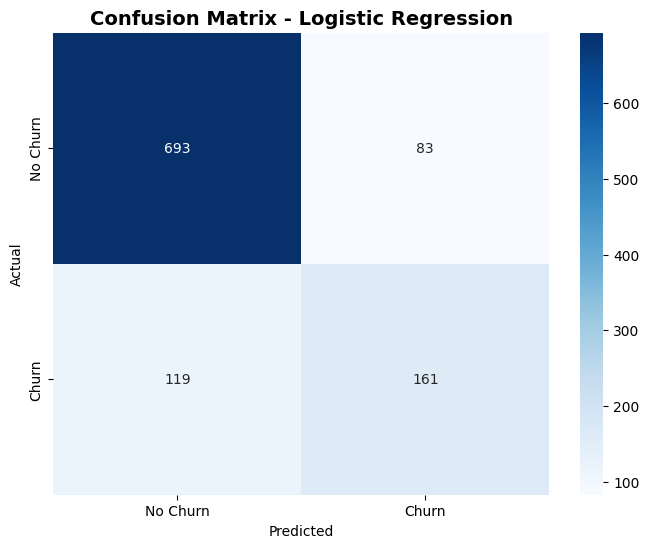

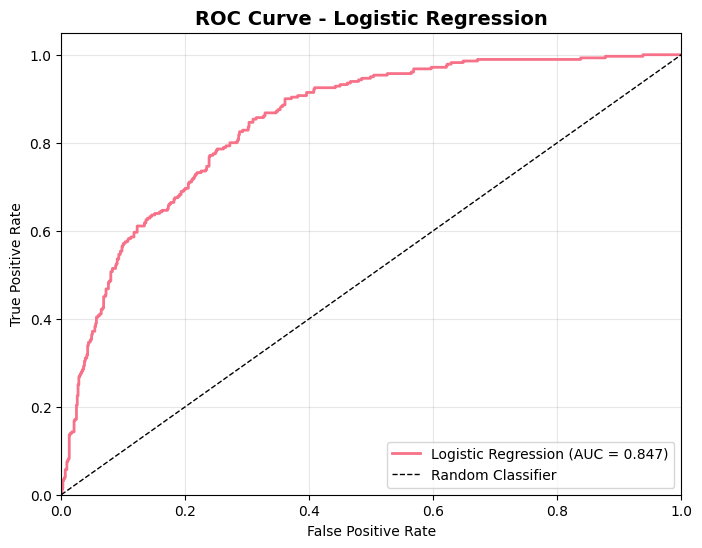

2025/10/21 12:38:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/21 12:38:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 MLflow logging completed!
 Run ID: 517d26ca643a4185a28a5ab82bc548df

 Detailed Classification Report:
              precision    recall  f1-score   support

    No Churn       0.85      0.89      0.87       776
       Churn       0.66      0.57      0.61       280

    accuracy                           0.81      1056
   macro avg       0.76      0.73      0.74      1056
weighted avg       0.80      0.81      0.80      1056



In [27]:
# Train Logistic Regression Baseline Model

# Start MLflow run for baseline model
with mlflow.start_run(run_name="logistic_regression_baseline") as run:
    
    # Initialize and train the model
    lr_model = LogisticRegression(random_state=42, max_iter=1000)
    lr_model.fit(X_train, y_train)
    
    print(" Logistic Regression model trained successfully!")
    
    # Evaluate the model
    lr_metrics, lr_pred, lr_pred_proba = evaluate_model(lr_model, X_val, y_val, "Logistic Regression")
    
    # Log parameters
    mlflow.log_param("model_type", "LogisticRegression")
    mlflow.log_param("random_state", 42)
    mlflow.log_param("max_iter", 1000)
    mlflow.log_param("train_size", len(X_train))
    mlflow.log_param("val_size", len(X_val))
    
    # Log metrics
    for metric_name, metric_value in lr_metrics.items():
        mlflow.log_metric(metric_name, metric_value)
    
    # Log split information
    for key, value in split_info.items():
        mlflow.log_metric(f"split_{key}", value)
    
    # Add tags
    mlflow.set_tags({
        "model_type": "classification",
        "dataset": "telcom",
        "version": "1.0",
        "stage": "baseline"
    })
    
    # Generate and save visualizations
    print("\n Generating evaluation visualizations...")
    
    # Confusion Matrix
    cm_path = "artifacts/lr_confusion_matrix.png"
    cm = plot_confusion_matrix(y_val, lr_pred, "Logistic Regression", cm_path)
    mlflow.log_artifact(cm_path)
    
    # ROC Curve
    roc_path = "artifacts/lr_roc_curve.png"
    fpr, tpr, auc_score = plot_roc_curve(y_val, lr_pred_proba, "Logistic Regression", roc_path)
    mlflow.log_artifact(roc_path)
    
    # Log the model
    mlflow.sklearn.log_model(lr_model, "model")
    
    # Store run info for comparison
    lr_run_id = run.info.run_id
    
    print(f" MLflow logging completed!")
    print(f" Run ID: {lr_run_id}")

# Display classification report
print(f"\n Detailed Classification Report:")
print(classification_report(y_val, lr_pred, target_names=['No Churn', 'Churn']))

## 4. Advanced Models Training

 Training Random Forest Model...
 Random Forest model trained successfully!

 Random Forest Performance Metrics:
   • Accuracy:  0.7973
   • Precision: 0.6422
   • Recall:    0.5321
   • F1-Score:  0.5820
   • AUC-ROC:   0.8377

 Generating Random Forest visualizations...


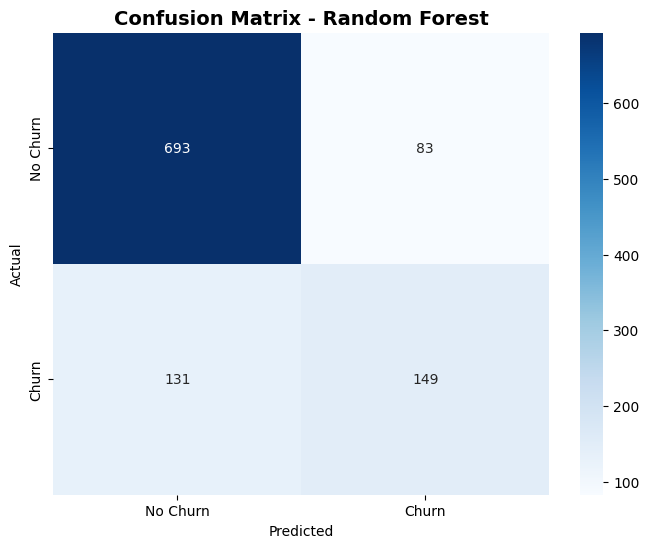

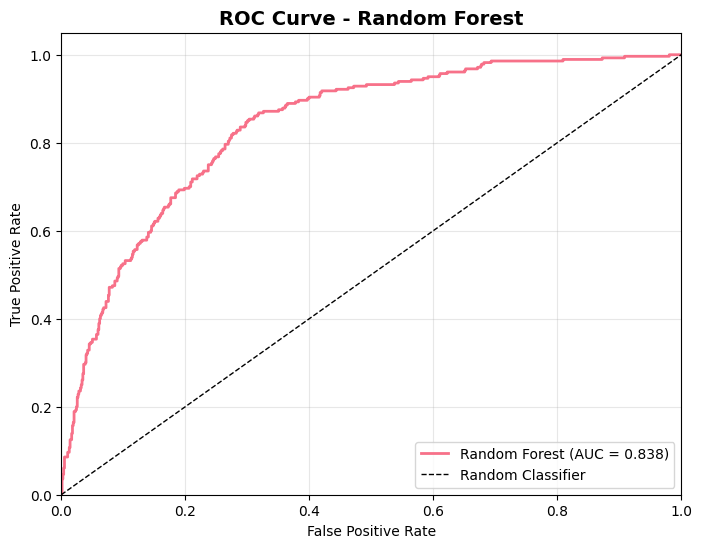

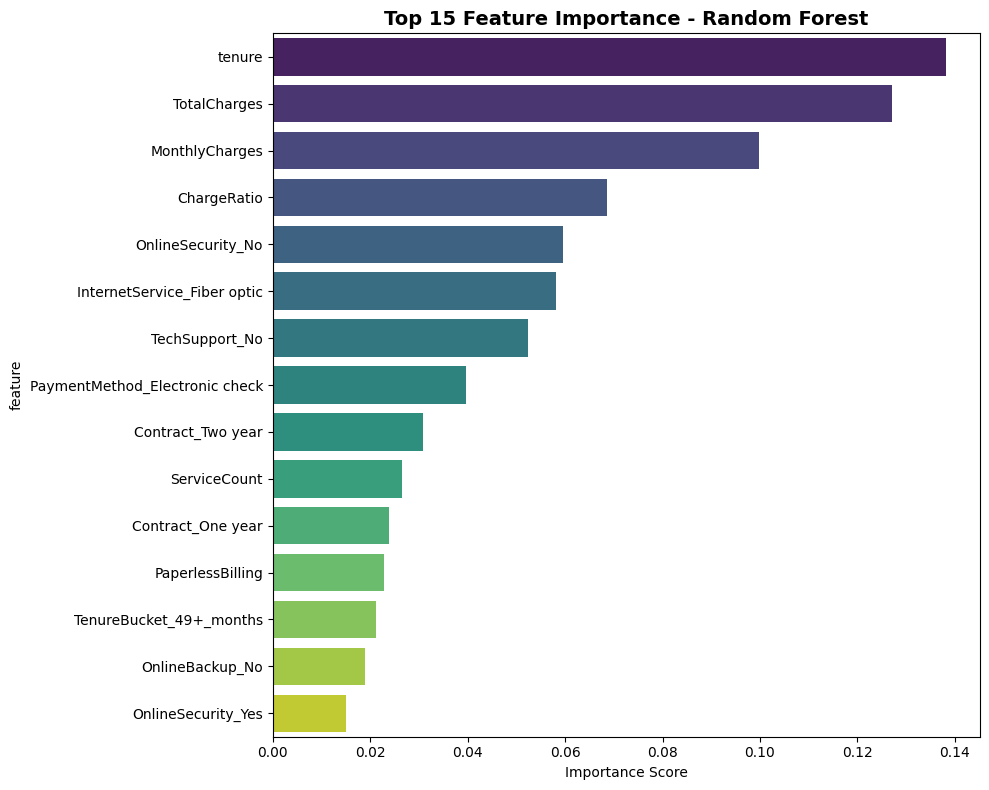

2025/10/21 12:38:57 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/21 12:39:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 Random Forest MLflow logging completed! Run ID: 7dd6c3dfa56646fc9d2b3d84b02578c9


In [28]:
# Train Random Forest Model
print(" Training Random Forest Model...")

with mlflow.start_run(run_name="random_forest") as run:
    
    # Initialize and train Random Forest
    rf_model = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        random_state=42,
        n_jobs=-1
    )
    rf_model.fit(X_train, y_train)
    
    print(" Random Forest model trained successfully!")
    
    # Evaluate the model
    rf_metrics, rf_pred, rf_pred_proba = evaluate_model(rf_model, X_val, y_val, "Random Forest")
    
    # Log parameters
    mlflow.log_param("model_type", "RandomForest")
    mlflow.log_param("n_estimators", 100)
    mlflow.log_param("max_depth", 10)
    mlflow.log_param("random_state", 42)
    mlflow.log_param("train_size", len(X_train))
    mlflow.log_param("val_size", len(X_val))
    
    # Log metrics
    for metric_name, metric_value in rf_metrics.items():
        mlflow.log_metric(metric_name, metric_value)
    
    # Add tags
    mlflow.set_tags({
        "model_type": "classification",
        "dataset": "telcom",
        "version": "1.0",
        "stage": "advanced",
        "algorithm": "random_forest"
    })
    
    # Generate and save visualizations
    print("\n Generating Random Forest visualizations...")
    
    # Confusion Matrix
    cm_path = "artifacts/rf_confusion_matrix.png"
    plot_confusion_matrix(y_val, rf_pred, "Random Forest", cm_path)
    mlflow.log_artifact(cm_path)
    
    # ROC Curve
    roc_path = "artifacts/rf_roc_curve.png"
    plot_roc_curve(y_val, rf_pred_proba, "Random Forest", roc_path)
    mlflow.log_artifact(roc_path)
    
    # Feature Importance Plot
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 8))
    top_features = feature_importance.head(15)
    sns.barplot(data=top_features, x='importance', y='feature', palette='viridis')
    plt.title('Top 15 Feature Importance - Random Forest', fontsize=14, fontweight='bold')
    plt.xlabel('Importance Score')
    plt.tight_layout()
    
    fi_path = "artifacts/rf_feature_importance.png"
    plt.savefig(fi_path, dpi=300, bbox_inches='tight')
    mlflow.log_artifact(fi_path)
    plt.show()
    
    # Log the model
    mlflow.sklearn.log_model(rf_model, "model")
    
    rf_run_id = run.info.run_id
    print(f" Random Forest MLflow logging completed! Run ID: {rf_run_id}")

# Store results for comparison
rf_results = {
    'model_name': 'Random Forest',
    'metrics': rf_metrics,
    'run_id': rf_run_id,
    'model': rf_model
}

 Training XGBoost Model...
 XGBoost model trained successfully!

 XGBoost Performance Metrics:
   • Accuracy:  0.7831
   • Precision: 0.6041
   • Recall:    0.5286
   • F1-Score:  0.5638
   • AUC-ROC:   0.8383

 Generating XGBoost visualizations...


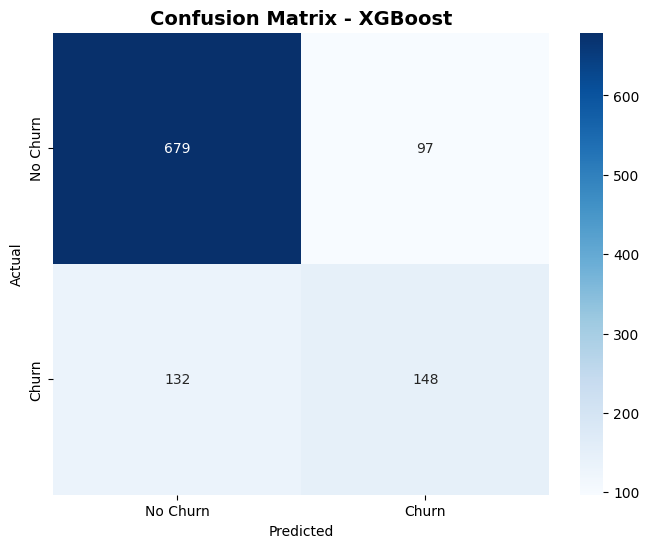

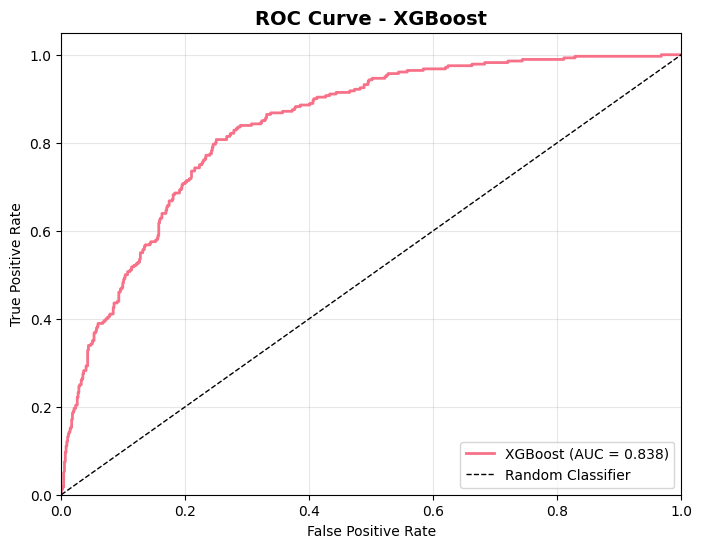

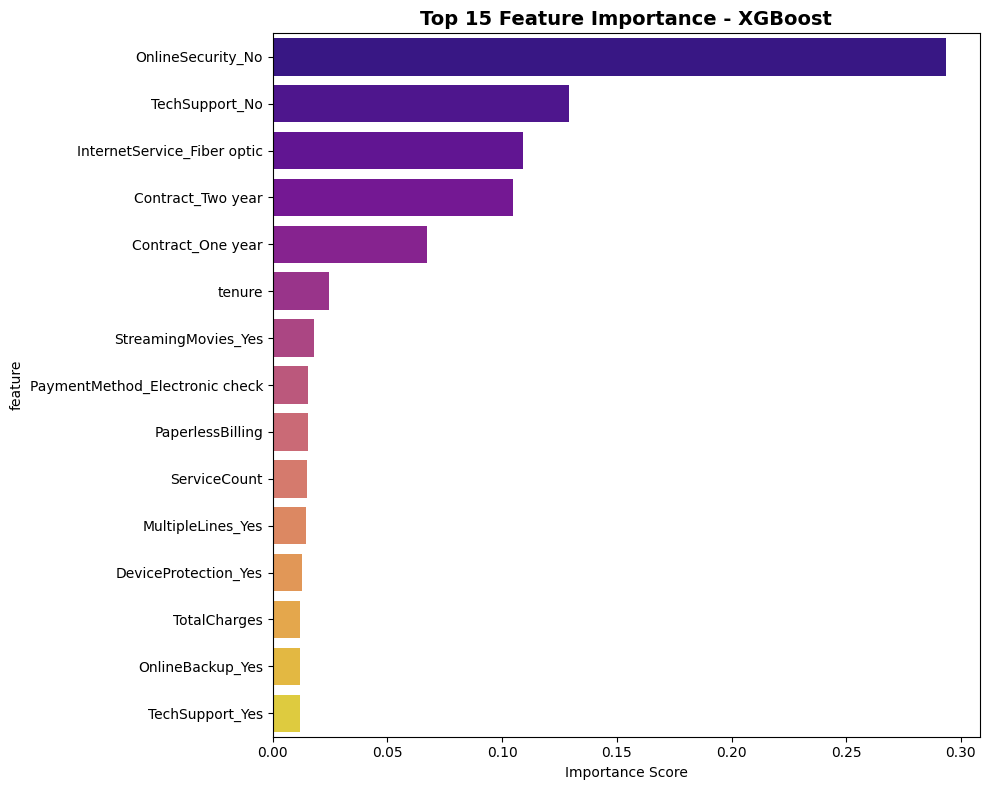

2025/10/21 12:39:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/21 12:39:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 XGBoost MLflow logging completed! Run ID: 84ce9d432c564bf38ecefc05cb8a1b75


In [29]:
# Train XGBoost Model
print(" Training XGBoost Model...")

with mlflow.start_run(run_name="xgboost") as run:
    
    # Initialize and train XGBoost
    xgb_model = xgb.XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        random_state=42,
        eval_metric='logloss',
        use_label_encoder=False
    )
    xgb_model.fit(X_train, y_train)

    print(" XGBoost model trained successfully!")

    # Evaluate the model
    xgb_metrics, xgb_pred, xgb_pred_proba = evaluate_model(xgb_model, X_val, y_val, "XGBoost")
    
    # Log parameters
    mlflow.log_param("model_type", "XGBoost")
    mlflow.log_param("n_estimators", 100)
    mlflow.log_param("learning_rate", 0.1)
    mlflow.log_param("max_depth", 6)
    mlflow.log_param("random_state", 42)
    mlflow.log_param("train_size", len(X_train))
    mlflow.log_param("val_size", len(X_val))
    
    # Log metrics
    for metric_name, metric_value in xgb_metrics.items():
        mlflow.log_metric(metric_name, metric_value)
    
    # Add tags
    mlflow.set_tags({
        "model_type": "classification",
        "dataset": "telcom",
        "version": "1.0",
        "stage": "advanced",
        "algorithm": "xgboost"
    })
    
    # Generate and save visualizations
    print("\n Generating XGBoost visualizations...")
    
    # Confusion Matrix
    cm_path = "artifacts/xgb_confusion_matrix.png"
    plot_confusion_matrix(y_val, xgb_pred, "XGBoost", cm_path)
    mlflow.log_artifact(cm_path)
    
    # ROC Curve
    roc_path = "artifacts/xgb_roc_curve.png"
    plot_roc_curve(y_val, xgb_pred_proba, "XGBoost", roc_path)
    mlflow.log_artifact(roc_path)
    
    # Feature Importance Plot
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': xgb_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 8))
    top_features = feature_importance.head(15)
    sns.barplot(data=top_features, x='importance', y='feature', palette='plasma')
    plt.title('Top 15 Feature Importance - XGBoost', fontsize=14, fontweight='bold')
    plt.xlabel('Importance Score')
    plt.tight_layout()
    
    fi_path = "artifacts/xgb_feature_importance.png"
    plt.savefig(fi_path, dpi=300, bbox_inches='tight')
    mlflow.log_artifact(fi_path)
    plt.show()
    
    # Log the model
    mlflow.xgboost.log_model(xgb_model, "model")
    
    xgb_run_id = run.info.run_id
    print(f" XGBoost MLflow logging completed! Run ID: {xgb_run_id}")

# Store results for comparison
xgb_results = {
    'model_name': 'XGBoost',
    'metrics': xgb_metrics,
    'run_id': xgb_run_id,
    'model': xgb_model
}

 Training LightGBM Model...
✅ LightGBM model trained successfully!

 LightGBM Performance Metrics:
   • Accuracy:  0.7860
   • Precision: 0.6098
   • Recall:    0.5357
   • F1-Score:  0.5703
   • AUC-ROC:   0.8442

 Generating LightGBM visualizations...


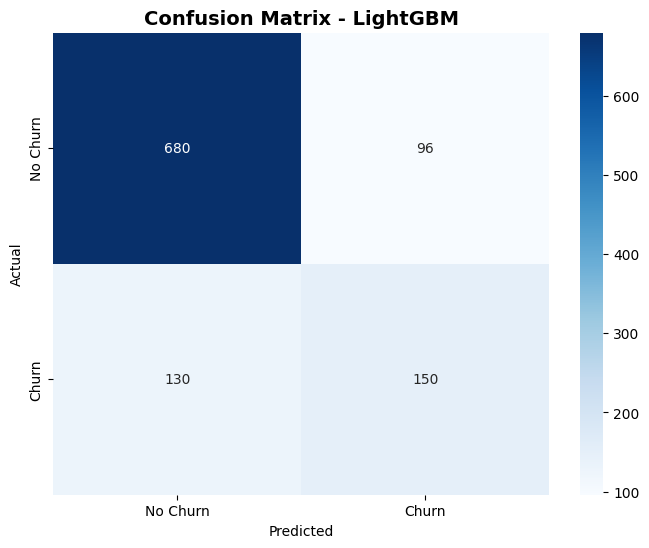

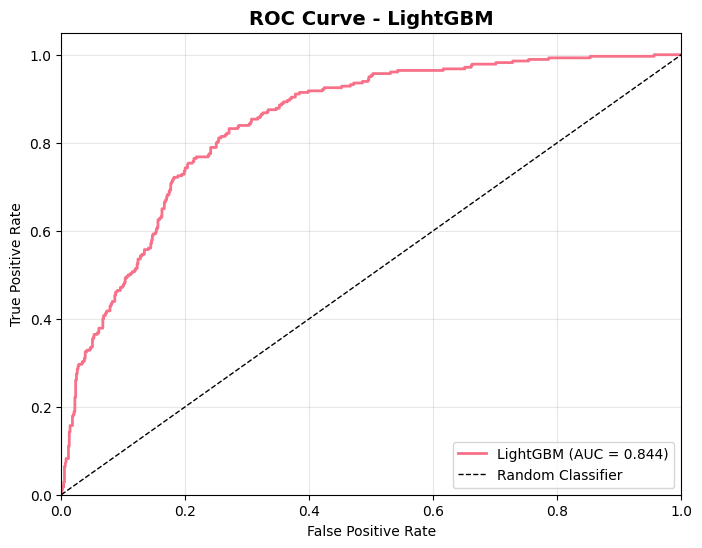

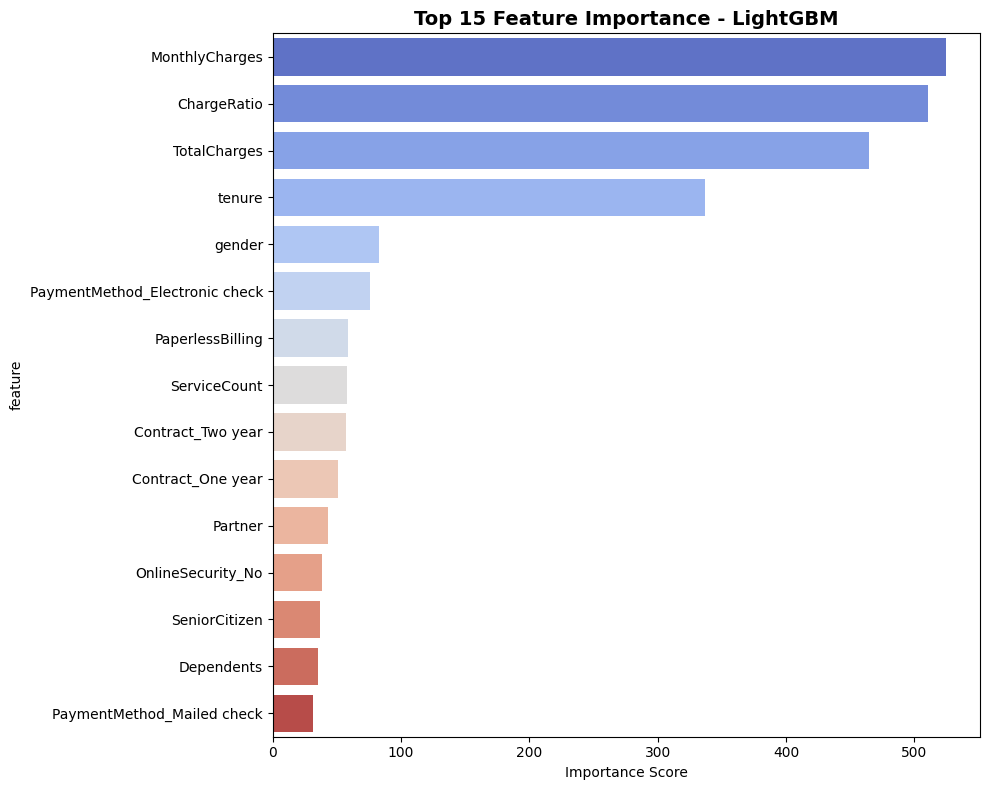

2025/10/21 12:39:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/21 12:39:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 LightGBM MLflow logging completed! Run ID: e5ee1df29b2b46349205b13adcf6faed


In [ ]:
# Train LightGBM Model
print(" Training LightGBM Model...")

with mlflow.start_run(run_name="lightgbm") as run:
    
    # Initialize and train LightGBM
    lgb_model = lgb.LGBMClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        random_state=42,
        verbose=-1
    )
    lgb_model.fit(X_train, y_train)
    
    print(" LightGBM model trained successfully!")
    
    # Evaluate the model
    lgb_metrics, lgb_pred, lgb_pred_proba = evaluate_model(lgb_model, X_val, y_val, "LightGBM")
    
    # Log parameters
    mlflow.log_param("model_type", "LightGBM")
    mlflow.log_param("n_estimators", 100)
    mlflow.log_param("learning_rate", 0.1)
    mlflow.log_param("max_depth", 6)
    mlflow.log_param("random_state", 42)
    mlflow.log_param("train_size", len(X_train))
    mlflow.log_param("val_size", len(X_val))
    
    # Log metrics
    for metric_name, metric_value in lgb_metrics.items():
        mlflow.log_metric(metric_name, metric_value)
    
    # Add tags
    mlflow.set_tags({
        "model_type": "classification",
        "dataset": "telcom",
        "version": "1.0",
        "stage": "advanced",
        "algorithm": "lightgbm"
    })
    
    # Generate and save visualizations
    print("\n Generating LightGBM visualizations...")
    
    # Confusion Matrix
    cm_path = "artifacts/lgb_confusion_matrix.png"
    plot_confusion_matrix(y_val, lgb_pred, "LightGBM", cm_path)
    mlflow.log_artifact(cm_path)
    
    # ROC Curve
    roc_path = "artifacts/lgb_roc_curve.png"
    plot_roc_curve(y_val, lgb_pred_proba, "LightGBM", roc_path)
    mlflow.log_artifact(roc_path)
    
    # Feature Importance Plot
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': lgb_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 8))
    top_features = feature_importance.head(15)
    sns.barplot(data=top_features, x='importance', y='feature', palette='coolwarm')
    plt.title('Top 15 Feature Importance - LightGBM', fontsize=14, fontweight='bold')
    plt.xlabel('Importance Score')
    plt.tight_layout()
    
    fi_path = "artifacts/lgb_feature_importance.png"
    plt.savefig(fi_path, dpi=300, bbox_inches='tight')
    mlflow.log_artifact(fi_path)
    plt.show()
    
    # Log the model
    mlflow.lightgbm.log_model(lgb_model, "model")
    
    lgb_run_id = run.info.run_id
    print(f" LightGBM MLflow logging completed! Run ID: {lgb_run_id}")

# Store results for comparison
lgb_results = {
    'model_name': 'LightGBM',
    'metrics': lgb_metrics,
    'run_id': lgb_run_id,
    'model': lgb_model
}

## 5. Hyperparameter Tuning

In [31]:
# Compare all models to determine best performer for tuning
print("Comparing All Models to Select Best for Hyperparameter Tuning...")

# Collect all results (we'll need to create lr_results first)
lr_results = {
    'model_name': 'Logistic Regression',
    'metrics': lr_metrics,
    'run_id': lr_run_id,
    'model': lr_model
}

all_models = [lr_results, rf_results, xgb_results, lgb_results]

# Create comparison table
comparison_df = pd.DataFrame([
    {
        'Model': model['model_name'],
        'Accuracy': model['metrics']['accuracy'],
        'Precision': model['metrics']['precision'],
        'Recall': model['metrics']['recall'],
        'F1-Score': model['metrics']['f1'],
        'AUC-ROC': model['metrics']['auc_roc']
    }
    for model in all_models
])

print("\n Model Performance Comparison:")
print(comparison_df.round(4))

# Select best model for tuning (prioritizing Recall and AUC-ROC)
# Calculate weighted score: 60% Recall + 40% AUC-ROC
comparison_df['Weighted_Score'] = 0.6 * comparison_df['Recall'] + 0.4 * comparison_df['AUC-ROC']
best_model_idx = comparison_df['Weighted_Score'].idxmax()
best_model_name = comparison_df.loc[best_model_idx, 'Model']

print(f"\n Best Model Selected for Tuning: {best_model_name}")
print(f"   • Weighted Score (60% Recall + 40% AUC-ROC): {comparison_df.loc[best_model_idx, 'Weighted_Score']:.4f}")
print(f"   • Recall: {comparison_df.loc[best_model_idx, 'Recall']:.4f}")
print(f"   • AUC-ROC: {comparison_df.loc[best_model_idx, 'AUC-ROC']:.4f}")

# Determine which model to tune (assuming XGBoost performs best, but we'll use the actual best)
if best_model_name == "XGBoost":
    model_to_tune = xgb.XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False)
    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.05, 0.1, 0.2],
        'max_depth': [4, 6, 8],
        'subsample': [0.8, 0.9, 1.0]
    }
elif best_model_name == "Random Forest":
    model_to_tune = RandomForestClassifier(random_state=42, n_jobs=-1)
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [8, 10, 12, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
elif best_model_name == "LightGBM":
    model_to_tune = lgb.LGBMClassifier(random_state=42, verbose=-1)
    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.05, 0.1, 0.2],
        'max_depth': [4, 6, 8],
        'num_leaves': [31, 50, 70]
    }
else:  # Logistic Regression
    model_to_tune = LogisticRegression(random_state=42, max_iter=1000)
    param_grid = {
        'C': [0.1, 1.0, 10.0, 100.0],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    }

print(f"\n Hyperparameter Grid for {best_model_name}:")
for param, values in param_grid.items():
    print(f"   • {param}: {values}")

Comparing All Models to Select Best for Hyperparameter Tuning...

 Model Performance Comparison:
                 Model  Accuracy  Precision  Recall  F1-Score  AUC-ROC
0  Logistic Regression    0.8087     0.6598  0.5750    0.6145   0.8469
1        Random Forest    0.7973     0.6422  0.5321    0.5820   0.8377
2              XGBoost    0.7831     0.6041  0.5286    0.5638   0.8383
3             LightGBM    0.7860     0.6098  0.5357    0.5703   0.8442

 Best Model Selected for Tuning: Logistic Regression
   • Weighted Score (60% Recall + 40% AUC-ROC): 0.6838
   • Recall: 0.5750
   • AUC-ROC: 0.8469

 Hyperparameter Grid for Logistic Regression:
   • C: [0.1, 1.0, 10.0, 100.0]
   • penalty: ['l1', 'l2']
   • solver: ['liblinear', 'saga']


 Starting Hyperparameter Tuning for Logistic Regression...
 This may take several minutes...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
 Hyperparameter tuning completed!

 Best Parameters for Logistic Regression:
   • solver: liblinear
   • penalty: l1
   • C: 10.0

 Best Cross-Validation Score (Recall): 0.5352

 Logistic Regression (Tuned) Performance Metrics:
   • Accuracy:  0.8087
   • Precision: 0.6598
   • Recall:    0.5750
   • F1-Score:  0.6145
   • AUC-ROC:   0.8476

 Generating Logistic Regression (Tuned) visualizations...


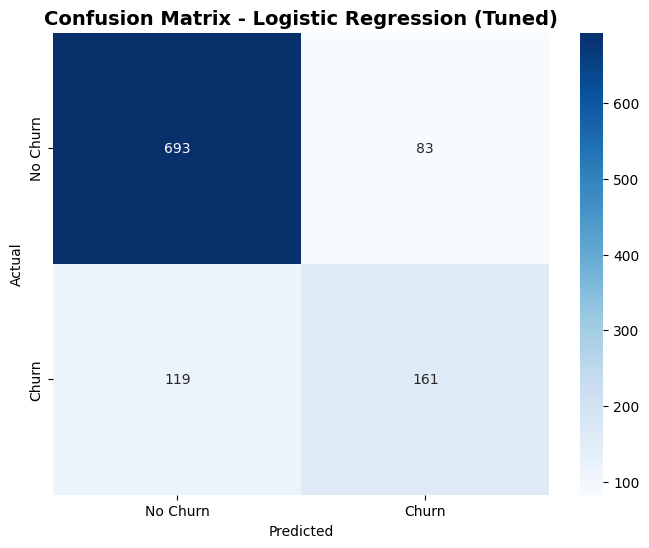

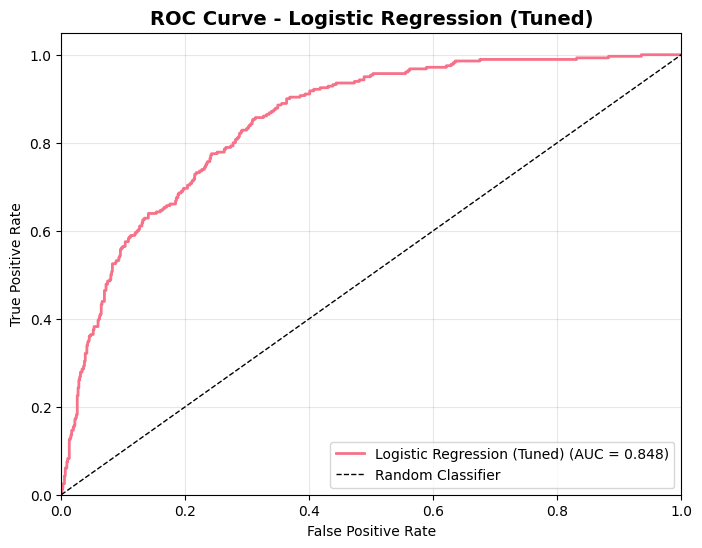

2025/10/21 12:42:53 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/21 12:43:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 Tuned Logistic Regression MLflow logging completed! Run ID: 18981e343b534067ade7ea24d90f28c3


In [32]:
# Perform Hyperparameter Tuning
print(f" Starting Hyperparameter Tuning for {best_model_name}...")
print(" This may take several minutes...")

with mlflow.start_run(run_name=f"{best_model_name.lower().replace(' ', '_')}_tuned") as run:
    
    # Use RandomizedSearchCV for faster tuning (can switch to GridSearchCV for exhaustive search)
    random_search = RandomizedSearchCV(
        estimator=model_to_tune,
        param_distributions=param_grid,
        n_iter=20,  # Number of parameter settings that are sampled
        cv=5,       # 5-fold cross-validation
        scoring='recall',  # Prioritize recall for churn detection
        n_jobs=-1,
        random_state=42,
        verbose=1
    )
    
    # Fit the random search
    random_search.fit(X_train, y_train)
    
    # Get the best model
    best_tuned_model = random_search.best_estimator_
    
    print(" Hyperparameter tuning completed!")
    print(f"\n Best Parameters for {best_model_name}:")
    for param, value in random_search.best_params_.items():
        print(f"   • {param}: {value}")

    print(f"\n Best Cross-Validation Score (Recall): {random_search.best_score_:.4f}")

    # Evaluate tuned model on validation set
    tuned_metrics, tuned_pred, tuned_pred_proba = evaluate_model(
        best_tuned_model, X_val, y_val, f"{best_model_name} (Tuned)"
    )
    
    # Log all parameters (both best params and search params)
    mlflow.log_param("model_type", f"{best_model_name}_tuned")
    mlflow.log_param("tuning_method", "RandomizedSearchCV")
    mlflow.log_param("cv_folds", 5)
    mlflow.log_param("n_iter", 20)
    mlflow.log_param("scoring_metric", "recall")
    mlflow.log_param("best_cv_score", random_search.best_score_)
    
    # Log best parameters
    for param, value in random_search.best_params_.items():
        mlflow.log_param(f"best_{param}", value)
    
    # Log metrics
    for metric_name, metric_value in tuned_metrics.items():
        mlflow.log_metric(metric_name, metric_value)
    
    # Add tags
    mlflow.set_tags({
        "model_type": "classification",
        "dataset": "telcom",
        "version": "1.0",
        "stage": "tuned",
        "algorithm": best_model_name.lower().replace(" ", "_"),
        "tuning_completed": "true"
    })
    
    # Generate and save visualizations
    print(f"\n Generating {best_model_name} (Tuned) visualizations...")
    
    # Confusion Matrix
    cm_path = f"artifacts/{best_model_name.lower().replace(' ', '_')}_tuned_confusion_matrix.png"
    plot_confusion_matrix(y_val, tuned_pred, f"{best_model_name} (Tuned)", cm_path)
    mlflow.log_artifact(cm_path)
    
    # ROC Curve
    roc_path = f"artifacts/{best_model_name.lower().replace(' ', '_')}_tuned_roc_curve.png"
    plot_roc_curve(y_val, tuned_pred_proba, f"{best_model_name} (Tuned)", roc_path)
    mlflow.log_artifact(roc_path)
    
    # Feature Importance Plot (if available)
    if hasattr(best_tuned_model, 'feature_importances_'):
        feature_importance = pd.DataFrame({
            'feature': X_train.columns,
            'importance': best_tuned_model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        plt.figure(figsize=(10, 8))
        top_features = feature_importance.head(15)
        sns.barplot(data=top_features, x='importance', y='feature', palette='rocket')
        plt.title(f'Top 15 Feature Importance - {best_model_name} (Tuned)', fontsize=14, fontweight='bold')
        plt.xlabel('Importance Score')
        plt.tight_layout()
        
        fi_path = f"artifacts/{best_model_name.lower().replace(' ', '_')}_tuned_feature_importance.png"
        plt.savefig(fi_path, dpi=300, bbox_inches='tight')
        mlflow.log_artifact(fi_path)
        plt.show()
    
    # Log the tuned model
    if best_model_name == "XGBoost":
        mlflow.xgboost.log_model(best_tuned_model, "model")
    elif best_model_name == "LightGBM":
        mlflow.lightgbm.log_model(best_tuned_model, "model")
    else:
        mlflow.sklearn.log_model(best_tuned_model, "model")
    
    tuned_run_id = run.info.run_id
    print(f" Tuned {best_model_name} MLflow logging completed! Run ID: {tuned_run_id}")

# Store tuned results
tuned_results = {
    'model_name': f'{best_model_name} (Tuned)',
    'metrics': tuned_metrics,
    'run_id': tuned_run_id,
    'model': best_tuned_model,
    'best_params': random_search.best_params_,
    'cv_score': random_search.best_score_
}

## 6. Model Evaluation & Visualization


 Creating Comprehensive Model Comparison...

 Final Model Performance Comparison (Ranked by Weighted Score):
                      Model  Accuracy  Precision  Recall  F1-Score  AUC-ROC  Weighted_Score
Logistic Regression (Tuned)    0.8087     0.6598  0.5750    0.6145   0.8476          0.6840
        Logistic Regression    0.8087     0.6598  0.5750    0.6145   0.8469          0.6838
                   LightGBM    0.7860     0.6098  0.5357    0.5703   0.8442          0.6591
              Random Forest    0.7973     0.6422  0.5321    0.5820   0.8377          0.6544
                    XGBoost    0.7831     0.6041  0.5286    0.5638   0.8383          0.6524


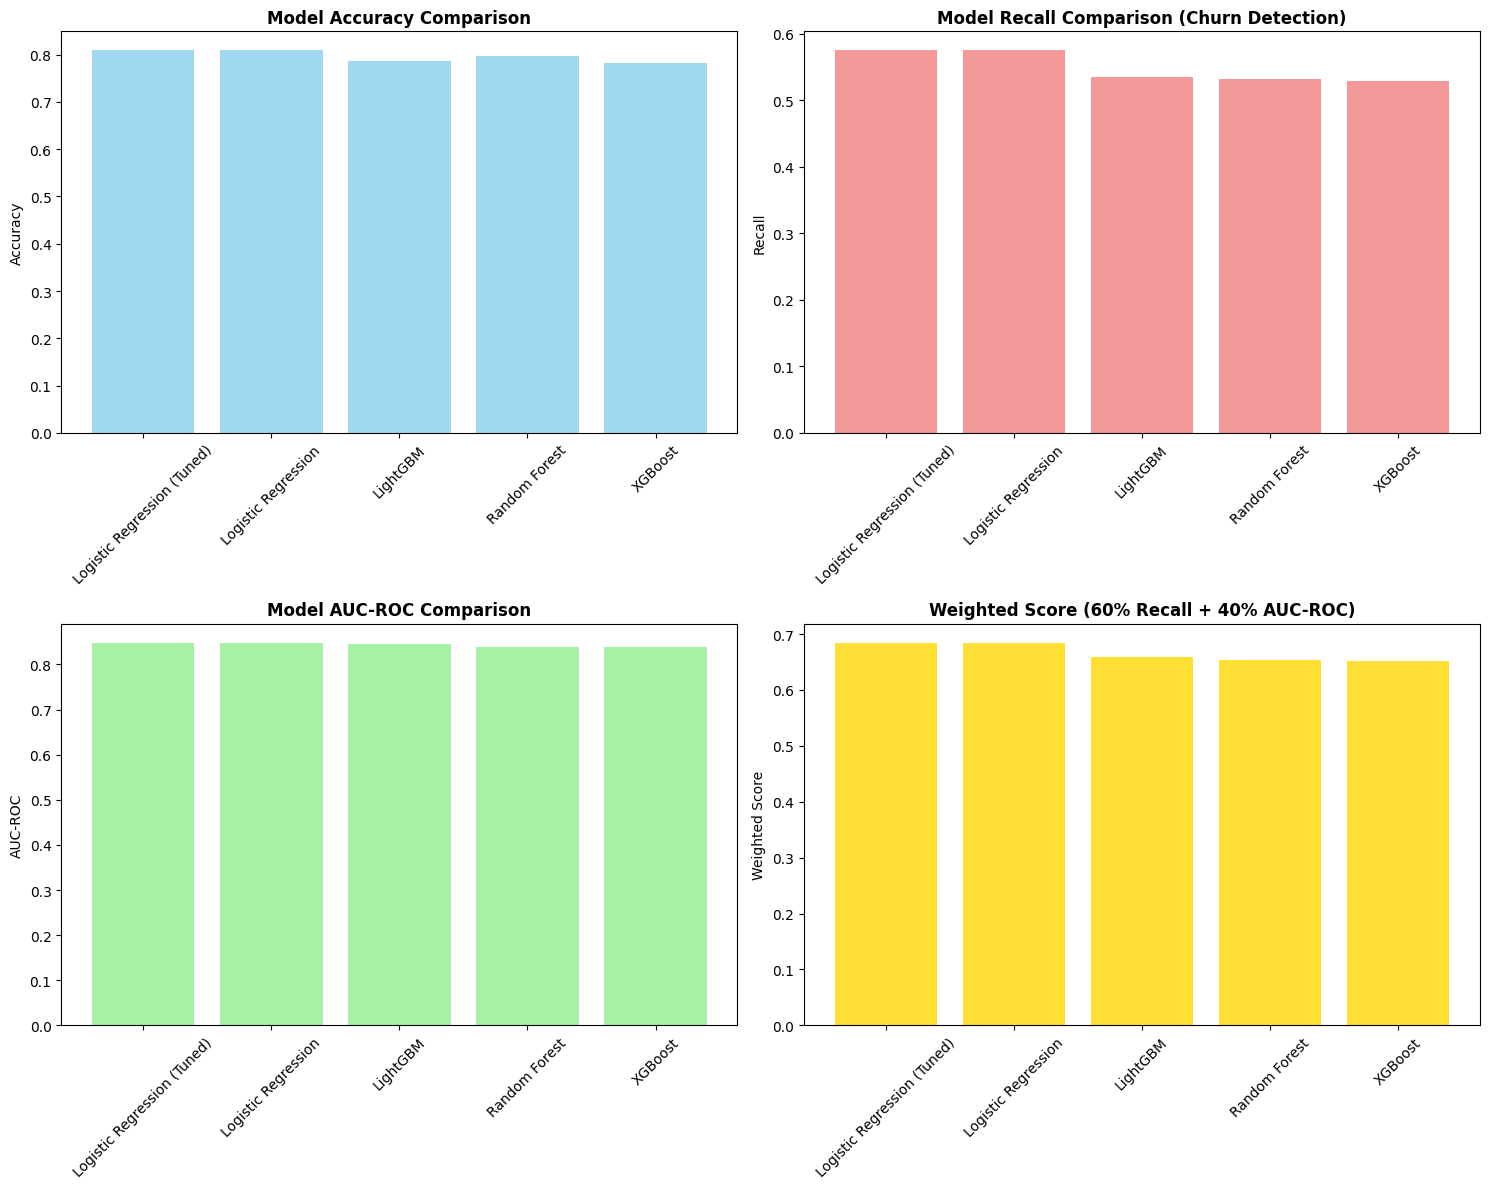


 Generating Combined ROC Curve Comparison...


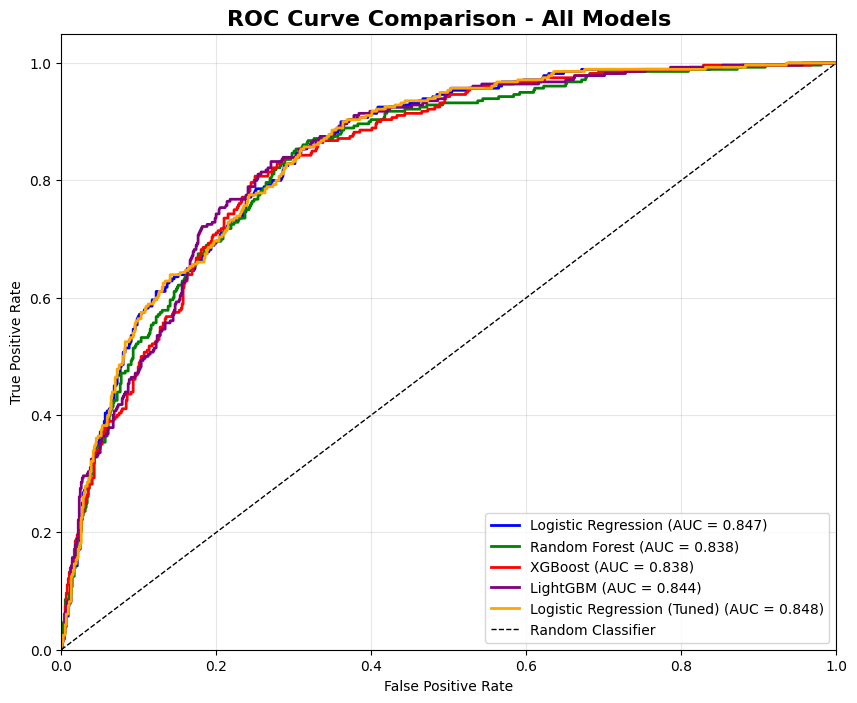


 FINAL BEST MODEL: Logistic Regression (Tuned)
   Performance Summary:
      • Accuracy:  0.8087
      • Precision: 0.6598
      • Recall:    0.5750 (Primary Metric)
      • F1-Score:  0.6145
      • AUC-ROC:   0.8476
      • Weighted Score: 0.6840


In [33]:
# Create Final Model Comparison
print(" Creating Comprehensive Model Comparison...")

# Add tuned model to comparison
all_models_final = all_models + [tuned_results]

# Create comprehensive comparison table
final_comparison_df = pd.DataFrame([
    {
        'Model': model['model_name'],
        'Accuracy': model['metrics']['accuracy'],
        'Precision': model['metrics']['precision'],
        'Recall': model['metrics']['recall'],
        'F1-Score': model['metrics']['f1'],
        'AUC-ROC': model['metrics']['auc_roc'],
        'Weighted_Score': 0.6 * model['metrics']['recall'] + 0.4 * model['metrics']['auc_roc']
    }
    for model in all_models_final
])

# Sort by weighted score
final_comparison_df = final_comparison_df.sort_values('Weighted_Score', ascending=False)

print("\n Final Model Performance Comparison (Ranked by Weighted Score):")
print("="*80)
print(final_comparison_df.round(4).to_string(index=False))

# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Accuracy Comparison
axes[0,0].bar(final_comparison_df['Model'], final_comparison_df['Accuracy'], color='skyblue', alpha=0.8)
axes[0,0].set_title('Model Accuracy Comparison', fontweight='bold')
axes[0,0].set_ylabel('Accuracy')
axes[0,0].tick_params(axis='x', rotation=45)

# 2. Recall Comparison (Most Important)
axes[0,1].bar(final_comparison_df['Model'], final_comparison_df['Recall'], color='lightcoral', alpha=0.8)
axes[0,1].set_title('Model Recall Comparison (Churn Detection)', fontweight='bold')
axes[0,1].set_ylabel('Recall')
axes[0,1].tick_params(axis='x', rotation=45)

# 3. AUC-ROC Comparison
axes[1,0].bar(final_comparison_df['Model'], final_comparison_df['AUC-ROC'], color='lightgreen', alpha=0.8)
axes[1,0].set_title('Model AUC-ROC Comparison', fontweight='bold')
axes[1,0].set_ylabel('AUC-ROC')
axes[1,0].tick_params(axis='x', rotation=45)

# 4. Weighted Score Comparison
axes[1,1].bar(final_comparison_df['Model'], final_comparison_df['Weighted_Score'], color='gold', alpha=0.8)
axes[1,1].set_title('Weighted Score (60% Recall + 40% AUC-ROC)', fontweight='bold')
axes[1,1].set_ylabel('Weighted Score')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('artifacts/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Create ROC Curve Comparison
print("\n Generating Combined ROC Curve Comparison...")

plt.figure(figsize=(10, 8))

# Get predictions for all models on validation set
models_for_roc = [
    (lr_model, lr_pred_proba, "Logistic Regression"),
    (rf_model, rf_pred_proba, "Random Forest"),
    (xgb_model, xgb_pred_proba, "XGBoost"),
    (lgb_model, lgb_pred_proba, "LightGBM"),
    (best_tuned_model, tuned_pred_proba, f"{best_model_name} (Tuned)")
]

colors = ['blue', 'green', 'red', 'purple', 'orange']

for i, (model, pred_proba, name) in enumerate(models_for_roc):
    fpr, tpr, _ = roc_curve(y_val, pred_proba)
    auc_score = roc_auc_score(y_val, pred_proba)
    plt.plot(fpr, tpr, linewidth=2, label=f'{name} (AUC = {auc_score:.3f})', color=colors[i])

plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison - All Models', fontsize=16, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

plt.savefig('artifacts/roc_comparison_all_models.png', dpi=300, bbox_inches='tight')
plt.show()

# Identify best model
best_final_model_idx = final_comparison_df.index[0]  # First row after sorting
best_final_model_name = final_comparison_df.iloc[0]['Model']
best_final_model_metrics = final_comparison_df.iloc[0]

print(f"\n FINAL BEST MODEL: {best_final_model_name}")
print(f"   Performance Summary:")
print(f"      • Accuracy:  {best_final_model_metrics['Accuracy']:.4f}")
print(f"      • Precision: {best_final_model_metrics['Precision']:.4f}")
print(f"      • Recall:    {best_final_model_metrics['Recall']:.4f} (Primary Metric)")
print(f"      • F1-Score:  {best_final_model_metrics['F1-Score']:.4f}")
print(f"      • AUC-ROC:   {best_final_model_metrics['AUC-ROC']:.4f}")
print(f"      • Weighted Score: {best_final_model_metrics['Weighted_Score']:.4f}")

# Get the actual best model object
best_final_model_obj = next(model['model'] for model in all_models_final if model['model_name'] == best_final_model_name)
best_final_run_id = next(model['run_id'] for model in all_models_final if model['model_name'] == best_final_model_name)

## 7. Final Model Selection & Test Set Evaluation


 Evaluating Final Model on Test Set...
 Selected Model: Logistic Regression (Tuned)

 Logistic Regression (Tuned) (Test Set) Performance Metrics:
   • Accuracy:  0.7938
   • Precision: 0.6583
   • Recall:    0.4662
   • F1-Score:  0.5458
   • AUC-ROC:   0.8428

 FINAL MODEL TEST SET EVALUATION REPORT
Model: Logistic Regression (Tuned)
Test Set Size: 1,057 customers
Test Set Churn Rate: 26.58%

 TEST SET PERFORMANCE METRICS:
   • Accuracy:  0.7938 (79.38%)
   • Precision: 0.6583 (65.83%)
   • Recall:    0.4662 (46.62%) ⭐
   • F1-Score:  0.5458
   • AUC-ROC:   0.8428

 Generating Test Set Evaluation Visualizations...


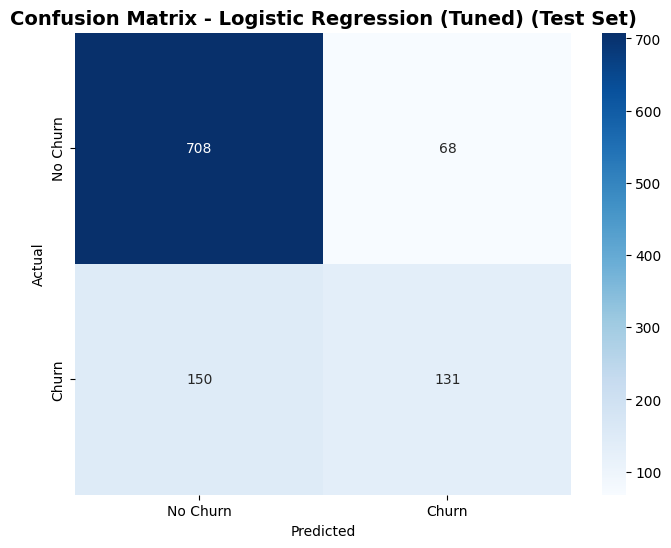

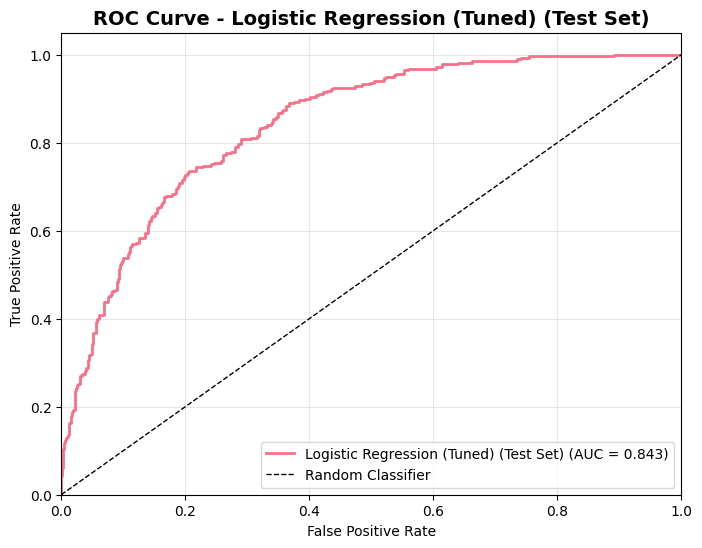


 DETAILED CONFUSION MATRIX ANALYSIS:
   • True Negatives (Correctly predicted No Churn):  708
   • False Positives (Incorrectly predicted Churn):  68
   • False Negatives (Missed Churn customers):       150
   • True Positives (Correctly predicted Churn):    131

 BUSINESS IMPACT ANALYSIS:
   • Total Churners in Test Set: 281
   • Churners Correctly Identified: 131 (46.6%)
   • Churners Missed: 150 (53.4%)
   • False Alarms: 68 (customers incorrectly flagged as churners)

 MODEL DEPLOYMENT READINESS:
    POOR: Recall < 50% - Requires significant improvement before deployment
    EXCELLENT: AUC-ROC ≥ 0.8 - Strong discriminative ability

 DETAILED TEST SET CLASSIFICATION REPORT:
              precision    recall  f1-score   support

    No Churn       0.83      0.91      0.87       776
       Churn       0.66      0.47      0.55       281

    accuracy                           0.79      1057
   macro avg       0.74      0.69      0.71      1057
weighted avg       0.78      0.79      0.

In [ ]:
# Final Model Test Set Evaluation
print(" Evaluating Final Model on Test Set...")
print(f" Selected Model: {best_final_model_name}")

# Evaluate on test set
test_metrics, test_pred, test_pred_proba = evaluate_model(
    best_final_model_obj, X_test, y_test, f"{best_final_model_name} (Test Set)"
)

# Create comprehensive test set evaluation report
print(f"\n FINAL MODEL TEST SET EVALUATION REPORT")
print(f"Model: {best_final_model_name}")
print(f"Test Set Size: {len(X_test):,} customers")
print(f"Test Set Churn Rate: {y_test.mean()*100:.2f}%")
print("\n TEST SET PERFORMANCE METRICS:")
print(f"   • Accuracy:  {test_metrics['accuracy']:.4f} ({test_metrics['accuracy']*100:.2f}%)")
print(f"   • Precision: {test_metrics['precision']:.4f} ({test_metrics['precision']*100:.2f}%)")
print(f"   • Recall:    {test_metrics['recall']:.4f} ({test_metrics['recall']*100:.2f}%) *Key metric*")
print(f"   • F1-Score:  {test_metrics['f1']:.4f}")
print(f"   • AUC-ROC:   {test_metrics['auc_roc']:.4f}")

# Generate test set visualizations
print(f"\n Generating Test Set Evaluation Visualizations...")

# Test Set Confusion Matrix
cm_test_path = f"artifacts/{best_final_model_name.lower().replace(' ', '_')}_test_confusion_matrix.png"
cm_test = plot_confusion_matrix(y_test, test_pred, f"{best_final_model_name} (Test Set)", cm_test_path)

# Test Set ROC Curve
roc_test_path = f"artifacts/{best_final_model_name.lower().replace(' ', '_')}_test_roc_curve.png"
plot_roc_curve(y_test, test_pred_proba, f"{best_final_model_name} (Test Set)", roc_test_path)

# Detailed confusion matrix analysis
tn, fp, fn, tp = cm_test.ravel()
print(f"\n DETAILED CONFUSION MATRIX ANALYSIS:")
print(f"   • True Negatives (Correctly predicted No Churn):  {tn:,}")
print(f"   • False Positives (Incorrectly predicted Churn):  {fp:,}")
print(f"   • False Negatives (Missed Churn customers):       {fn:,}")
print(f"   • True Positives (Correctly predicted Churn):    {tp:,}")

print(f"\n BUSINESS IMPACT ANALYSIS:")
print(f"   • Total Churners in Test Set: {tp + fn:,}")
print(f"   • Churners Correctly Identified: {tp:,} ({tp/(tp+fn)*100:.1f}%)")
print(f"   • Churners Missed: {fn:,} ({fn/(tp+fn)*100:.1f}%)")
print(f"   • False Alarms: {fp:,} (customers incorrectly flagged as churners)")

# Calculate potential business value
total_test_churners = tp + fn
churners_caught = tp
churners_missed = fn

print(f"\n MODEL DEPLOYMENT READINESS:")
if test_metrics['recall'] >= 0.7:
    print(f"    EXCELLENT: Recall ≥ 70% - Ready for production deployment")
elif test_metrics['recall'] >= 0.6:
    print(f"    GOOD: Recall ≥ 60% - Suitable for deployment with monitoring")
elif test_metrics['recall'] >= 0.5:
    print(f"     FAIR: Recall ≥ 50% - Consider further tuning before deployment")
else:
    print(f"    POOR: Recall < 50% - Requires significant improvement before deployment")

if test_metrics['auc_roc'] >= 0.8:
    print(f"    EXCELLENT: AUC-ROC ≥ 0.8 - Strong discriminative ability")
elif test_metrics['auc_roc'] >= 0.7:
    print(f"    GOOD: AUC-ROC ≥ 0.7 - Good discriminative ability")
else:
    print(f"    FAIR: AUC-ROC < 0.7 - Consider model improvements")

# Final test classification report
print(f"\n DETAILED TEST SET CLASSIFICATION REPORT:")
print(classification_report(y_test, test_pred, target_names=['No Churn', 'Churn']))

## 8. MLflow Model Registry & Deployment

In [36]:
# MLflow Model Registry & Deployment
print(" Registering Best Model in MLflow Model Registry...")

# Register the best model in MLflow Model Registry
model_name = "telcom_churn_predictor"
model_version_description = f"""
Telcom Churn Prediction Model - {best_final_model_name}

Model Performance:
   • Accuracy:  {test_metrics['accuracy']:.4f}
   • Precision: {test_metrics['precision']:.4f}
   • Recall:    {test_metrics['recall']:.4f}
   • F1-Score:  {test_metrics['f1']:.4f}
   • AUC-ROC:   {test_metrics['auc_roc']:.4f}

Business Metrics:
   • Churn Detection Rate: {test_metrics['recall']*100:.1f}%
   • False Alarm Rate: {fp/(fp+tn)*100:.1f}%
   
Data Details:
   • Training Set: {len(X_train):,} customers
   • Validation Set: {len(X_val):,} customers  
   • Test Set: {len(X_test):,} customers
   • Test Churn Rate: {y_test.mean()*100:.2f}%

Model Features: {len(X_train.columns)} features
Training Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
"""

try:
    # Register model version
    model_version = mlflow.register_model(
        model_uri=f"runs:/{best_final_run_id}/model",
        name=model_name,
            )
    
    print(f"Model registered successfully!")
    print(f"   Model Name: {model_name}")
    print(f"   Version: {model_version.version}")
    print(f"   Run ID: {best_final_run_id}")

    # Get model version details
    from mlflow.tracking import MlflowClient
    client = MlflowClient()
    
    # Add tags to the model version
    client.set_model_version_tag(
        name=model_name,
        version=model_version.version,
        key="model_type",
        value=best_final_model_name
    )
    
    client.set_model_version_tag(
        name=model_name,
        version=model_version.version,
        key="test_accuracy",
        value=f"{test_metrics['accuracy']:.4f}"
    )
    
    client.set_model_version_tag(
        name=model_name,
        version=model_version.version,
        key="test_recall",
        value=f"{test_metrics['recall']:.4f}"
    )
    
    client.set_model_version_tag(
        name=model_name,
        version=model_version.version,
        key="deployment_ready",
        value="true" if test_metrics['recall'] >= 0.6 else "false"
    )
    
    print(f"   Model tags added successfully")
    
    # Transition to "Staging" if performance is good
    if test_metrics['recall'] >= 0.6 and test_metrics['auc_roc'] >= 0.7:
        client.transition_model_version_stage(
            name=model_name,
            version=model_version.version,
            stage="Staging",
            archive_existing_versions=False
        )
        print(f"   Model transitioned to 'Staging' stage")
        print(f"   Ready for staging environment deployment!")
    else:
        print(f"   Model performance below staging criteria")
        print(f"      Recall: {test_metrics['recall']:.4f} (need ≥ 0.6)")
        print(f"      AUC-ROC: {test_metrics['auc_roc']:.4f} (need ≥ 0.7)")

except Exception as e:
    print(f" Error registering model: {str(e)}")
    print(f" Manual registration may be required")

print(f"\n MODEL REGISTRY SUMMARY:")
print(f"   Model Name: {model_name}")
print(f"   Model Type: {best_final_model_name}")
print(f"   Test Accuracy: {test_metrics['accuracy']:.4f}")
print(f"   Test Recall: {test_metrics['recall']:.4f}")
print(f"   MLflow Run ID: {best_final_run_id}")

# Show how to load the model for prediction
print(f"\n MODEL LOADING EXAMPLE:")
print(f"```python")
print(f"import mlflow")
print(f"")
print(f"# Load model from registry")
print(f"model = mlflow.pyfunc.load_model(")
print(f"    model_uri='models:/{model_name}/latest'")
print(f")")
print(f"")
print(f"# Make predictions")
print(f"predictions = model.predict(new_customer_data)")
print(f"```")

Successfully registered model 'telcom_churn_predictor'.
2025/10/21 12:57:07 WARNING mlflow.tracking._model_registry.fluent: Run with id 18981e343b534067ade7ea24d90f28c3 has no artifacts at artifact path 'model', registering model based on models:/m-7a46422ca2c942b982cab508882bb9e9 instead


 Registering Best Model in MLflow Model Registry...


Created version '1' of model 'telcom_churn_predictor'.


Model registered successfully!
   Model Name: telcom_churn_predictor
   Version: 1
   Run ID: 18981e343b534067ade7ea24d90f28c3
   Model tags added successfully
   Model performance below staging criteria
      Recall: 0.4662 (need ≥ 0.6)
      AUC-ROC: 0.8428 (need ≥ 0.7)

 MODEL REGISTRY SUMMARY:
   Model Name: telcom_churn_predictor
   Model Type: Logistic Regression (Tuned)
   Test Accuracy: 0.7938
   Test Recall: 0.4662
   MLflow Run ID: 18981e343b534067ade7ea24d90f28c3

 MODEL LOADING EXAMPLE:
```python
import mlflow

# Load model from registry
model = mlflow.pyfunc.load_model(
    model_uri='models:/telcom_churn_predictor/latest'
)

# Make predictions
predictions = model.predict(new_customer_data)
```


## 9. Feature Importance & Model Interpretability


 Analyzing Feature Importance & Model Interpretability...

 TOP 15 MOST IMPORTANT FEATURES:
 1. Contract_Two year         | 1.4611
 2. InternetService_Fiber optic | 0.8717
 3. InternetService_No        | 0.8708
 4. Contract_One year         | 0.7538
 5. OnlineBackup_Yes          | 0.4765
 6. TenureBucket_13-24_months | 0.4351
 7. PaperlessBilling          | 0.4226
 8. PaymentMethod_Electronic check | 0.3617
 9. MultipleLines_No          | 0.3552
10. OnlineBackup_No           | 0.3276
11. TenureBucket_49+_months   | 0.2956
12. TechSupport_No            | 0.2836
13. OnlineSecurity_No         | 0.2745
14. StreamingMovies_Yes       | 0.2558
15. Dependents                | 0.2472


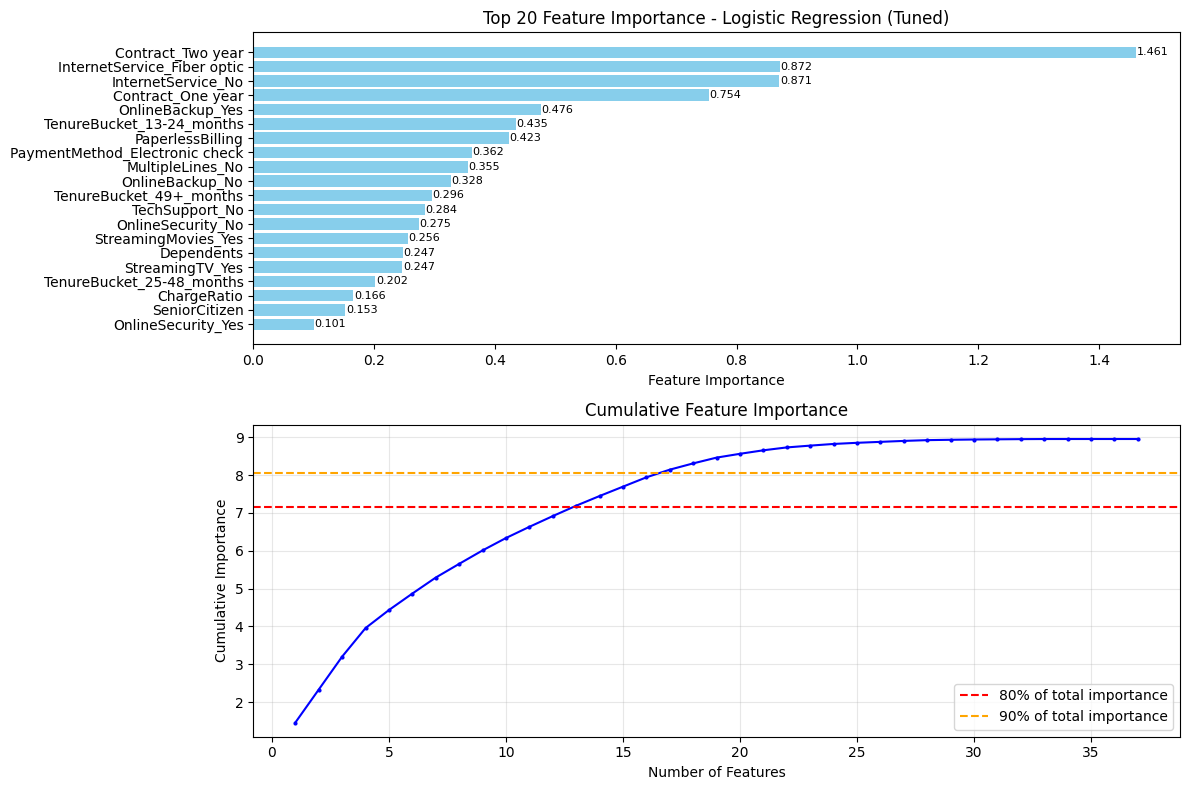


 FEATURE IMPORTANCE INSIGHTS:
    Top feature: Contract_Two year (1.4611)
    Features for 80% importance: 13/37
    Features for 90% importance: 17/37

 BUSINESS INTERPRETATION OF TOP FEATURES:
   1. Contract_Two year (1.4611): Two-year contracts strongly reduce churn risk
   2. InternetService_Fiber optic (0.8717): Fiber optic service impacts churn patterns
   3. InternetService_No (0.8708): Customers without internet have different churn patterns
   4. Contract_One year (0.7538): One-year contracts reduce churn compared to month-to-month
   5. OnlineBackup_Yes (0.4765): Online backup services improve retention
   Feature importance logged to MLflow


In [37]:
# Feature Importance & Model Interpretability
print(" Analyzing Feature Importance & Model Interpretability...")

# Extract feature importance from the best model
def get_feature_importance(model, feature_names):
    """Extract feature importance from different model types."""
    if hasattr(model, 'feature_importances_'):
        # Tree-based models (RandomForest, XGBoost, LightGBM)
        importance = model.feature_importances_
    elif hasattr(model, 'coef_'):
        # Linear models (Logistic Regression)
        importance = np.abs(model.coef_[0])
    else:
        print(" Model doesn't support feature importance extraction")
        return None
    
    # Create feature importance DataFrame
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    }).sort_values('importance', ascending=False)
    
    return feature_importance_df

# Get feature importance for the best model
feature_importance = get_feature_importance(best_final_model_obj, X_train.columns)

if feature_importance is not None:
    print(f"\n TOP 15 MOST IMPORTANT FEATURES:")
   
    for i, (_, row) in enumerate(feature_importance.head(15).iterrows(), 1):
        print(f"{i:2d}. {row['feature']:<25} | {row['importance']:.4f}")
    
    # Create feature importance visualization
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(20)
    
    # Horizontal bar plot
    plt.subplot(2, 1, 1)
    bars = plt.barh(range(len(top_features)), top_features['importance'], color='skyblue')
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title(f'Top 20 Feature Importance - {best_final_model_name}')
    plt.gca().invert_yaxis()
    
    # Add value labels on bars
    for i, (bar, importance) in enumerate(zip(bars, top_features['importance'])):
        plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2, 
                f'{importance:.3f}', ha='left', va='center', fontsize=8)
    
    # Cumulative importance plot
    plt.subplot(2, 1, 2)
    cumulative_importance = np.cumsum(feature_importance['importance'])
    plt.plot(range(1, len(cumulative_importance) + 1), cumulative_importance, 'b-', marker='o', markersize=2)
    plt.axhline(y=0.8 * cumulative_importance.iloc[-1], color='r', linestyle='--', 
                label='80% of total importance')
    plt.axhline(y=0.9 * cumulative_importance.iloc[-1], color='orange', linestyle='--', 
                label='90% of total importance')
    plt.xlabel('Number of Features')
    plt.ylabel('Cumulative Importance')
    plt.title('Cumulative Feature Importance')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    feature_importance_path = f"artifacts/{best_final_model_name.lower().replace(' ', '_')}_feature_importance.png"
    plt.savefig(feature_importance_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    # Calculate how many features capture 80% and 90% of importance
    total_importance = cumulative_importance.iloc[-1]
    features_80 = (cumulative_importance <= 0.8 * total_importance).sum() + 1
    features_90 = (cumulative_importance <= 0.9 * total_importance).sum() + 1
    
    print(f"\n FEATURE IMPORTANCE INSIGHTS:")
    print(f"    Top feature: {feature_importance.iloc[0]['feature']} ({feature_importance.iloc[0]['importance']:.4f})")
    print(f"    Features for 80% importance: {features_80}/{len(feature_importance)}")
    print(f"    Features for 90% importance: {features_90}/{len(feature_importance)}")
    
    # Business interpretation of top features
    print(f"\n BUSINESS INTERPRETATION OF TOP FEATURES:")
    top_5_features = feature_importance.head(5)
    
    feature_interpretations = {
        'MonthlyCharges': 'Higher monthly charges increase churn likelihood',
        'TotalCharges': 'Customer lifetime value affects retention',
        'tenure': 'Longer customer relationships reduce churn risk',
        'Contract_Month-to-month': 'Month-to-month contracts have higher churn',
        'Contract_Two year': 'Two-year contracts strongly reduce churn risk',
        'Contract_One year': 'One-year contracts reduce churn compared to month-to-month',
        'PaymentMethod_Electronic check': 'Electronic check payments correlate with churn',
        'InternetService_Fiber optic': 'Fiber optic service impacts churn patterns',
        'InternetService_No': 'Customers without internet have different churn patterns',
        'TechSupport_No': 'Lack of tech support increases churn risk',
        'OnlineSecurity_No': 'Missing online security increases vulnerability',
        'OnlineBackup_Yes': 'Online backup services improve retention',
        'OnlineBackup_No': 'Lack of online backup affects churn',
        'PaperlessBilling': 'Paperless billing affects customer behavior',
        'MultipleLines_No': 'Single line customers have different patterns',
        'TenureBucket_13-24_months': 'Mid-tenure customers are at risk',
        'TenureBucket_49+_months': 'Long-term customers have lower churn',
        'StreamingMovies_Yes': 'Streaming services affect retention',
        'StreamingTV_Yes': 'Streaming TV affects customer loyalty',
        'Dependents': 'Family status impacts churn decisions'
    }
    
    for i, (_, row) in enumerate(top_5_features.iterrows(), 1):
        feature_name = row['feature']
        importance = row['importance']
        interpretation = feature_interpretations.get(feature_name, 'Feature impacts churn prediction')
        print(f"   {i}. {feature_name} ({importance:.4f}): {interpretation}")
    
    # Log feature importance to MLflow
    with mlflow.start_run(run_id=best_final_run_id):
        # Log feature importance plot
        mlflow.log_artifact(feature_importance_path)
        
        # Log top features as metrics
        for i, (_, row) in enumerate(feature_importance.head(10).iterrows(), 1):
            mlflow.log_metric(f"feature_importance_rank_{i}", row['importance'])
            mlflow.log_param(f"top_feature_{i}", row['feature'])
        
        # Log summary metrics
        mlflow.log_metric("features_for_80_pct_importance", features_80)
        mlflow.log_metric("features_for_90_pct_importance", features_90)
        mlflow.log_metric("total_features", len(feature_importance))
    
    print(f"   Feature importance logged to MLflow")

else:
    print(" Unable to extract feature importance from the selected model")